In [40]:
from pprint import pprint
import time
import ee
import folium
import csv
import sys
import tensorflow as tf
from tensorflow import keras
import json
import numpy as np
import matplotlib.pyplot as plt

In [41]:
print(tf.__version__)
print(sys.version)

2.1.0
3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]


In [ ]:
ee.Authenticate()

In [43]:
ee.Initialize()

In [44]:
# Use these bands for prediction.
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
# Use Landsat 8 surface reflectance data.
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

# Cloud masking function.
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  return image.updateMask(mask).select(bands).divide(10000)

# The image input data is a 2018 cloud-masked median composite.
image = l8sr.filterDate('2018-01-01', '2018-12-31').map(maskL8sr).median()

# Use folium to visualize the imagery.
mapIdDict = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[45.4, -75.7])
folium.TileLayer(
    tiles=mapIdDict['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [45]:
trainFileCSV = '../TFData/Training Export.csv'
testFileCSV = '../TFData/Testing Export.csv'

print('Found training file.' if tf.io.gfile.exists(trainFileCSV) 
    else 'No training file found.')
print('Found testing file.' if tf.io.gfile.exists(testFileCSV) 
    else 'No testing file found.')

Found training file.
Found testing file.


In [46]:
trainCSV = np.genfromtxt(trainFileCSV, delimiter=',', names=True)
trainCSV['B4']

array([0.0522 , 0.03885, 0.0243 , ..., 0.04945, 0.1699 , 0.11725])

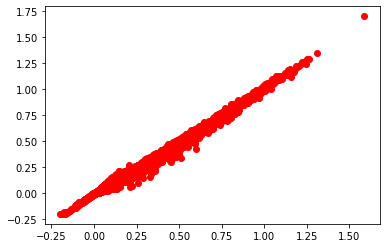

In [9]:
plt.plot(trainCSV['B3'], trainCSV['B4'], 'ro')

In [10]:
trainFilePath = '../TFData/Training Export.tfrecord.gz'
testFilePath = '../TFData/Testing Export.tfrecord.gz'

print('Found training file.' if tf.io.gfile.exists(trainFilePath) 
    else 'No training file found.')
print('Found testing file.' if tf.io.gfile.exists(testFilePath) 
    else 'No testing file found.')

Found training file.
Found testing file.


In [11]:
# Create a dataset from the TFRecord file in Cloud Storage.
trainDataset = tf.data.TFRecordDataset(trainFilePath, compression_type='GZIP')
# Print the first record to check.
print(iter(trainDataset).next())

tf.Tensor(b'\n`\n\x0e\n\x02B2\x12\x08\x12\x06\n\x04vO\x1e=\n\x0e\n\x02B3\x12\x08\x12\x06\n\x04\xd4\x9af=\n\x0e\n\x02B4\x12\x08\x12\x06\n\x04\xab\xcfU=\n\x0e\n\x02B5\x12\x08\x12\x06\n\x04\x16\xfbK>\n\x0e\n\x02B6\x12\x08\x12\x06\n\x04\xb0r\x08>\n\x0e\n\x02B7\x12\x08\x12\x06\n\x04\x1e\xa7\xa8=', shape=(), dtype=string)


In [12]:
# This is list of all the properties we want to export.
featureNames = list(bands)

# List of fixed-length features, all of which are float32.
columns = [
  tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in featureNames
]

# Dictionary with names as keys, features as values.
featuresDict = dict(zip(featureNames, columns))

pprint(featuresDict)

{'B2': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B3': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B4': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B5': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B6': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None),
 'B7': FixedLenFeature(shape=[1], dtype=tf.float32, default_value=None)}


In [13]:
def parse_tfrecord(example_proto):
  parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
  band4 = parsed_features.pop('B4')
  return parsed_features, band4

# Map the function over the dataset.
parsedDataset = trainDataset.map(parse_tfrecord, num_parallel_calls=5)

# Print the first parsed record to check.
pprint(iter(parsedDataset).next())

({'B2': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.03865], dtype=float32)>,
  'B3': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0563], dtype=float32)>,
  'B5': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1992], dtype=float32)>,
  'B6': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.13325], dtype=float32)>,
  'B7': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.08235], dtype=float32)>},
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0522], dtype=float32)>)


In [33]:
def toTuple(dict, label):
  return tf.transpose(list(dict.values())), label

# Define the layers in the model.
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.tanh),
  tf.keras.layers.Dense(10)
])

inputDataset = parsedDataset.map(toTuple)
pprint(iter(inputDataset).next())

# Compile the model with the specified loss function.
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss='mean_squared_error',
              metrics=['MAE'])

(<tf.Tensor: shape=(1, 5), dtype=float32, numpy=array([[0.03865, 0.0563 , 0.1992 , 0.13325, 0.08235]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0522], dtype=float32)>)


In [34]:
# Fit the model to the training data.
model.fit(x=inputDataset, epochs=10)

testDataset = (
  tf.data.TFRecordDataset(testFilePath, compression_type='GZIP')
    .map(parse_tfrecord, num_parallel_calls=5)
    .map(toTuple)
)

model.evaluate(testDataset)

Epoch 1/10
21334/21334 [==============================] - 90s 4ms/step - loss: 0.0050 - MAE: 0.0352
Epoch 2/10
21334/21334 [==============================] - 39s 2ms/step - loss: 8.9423e-04 - MAE: 0.0192
Epoch 3/10
21334/21334 [==============================] - 30s 1ms/step - loss: 7.0322e-04 - MAE: 0.0166
Epoch 4/10
21334/21334 [==============================] - 36s 2ms/step - loss: 6.0674e-04 - MAE: 0.0153
Epoch 5/10
21334/21334 [==============================] - 36s 2ms/step - loss: 5.4379e-04 - MAE: 0.0145
Epoch 6/10
21334/21334 [==============================] - 40s 2ms/step - loss: 4.9744e-04 - MAE: 0.0138
Epoch 7/10
21334/21334 [==============================] - 39s 2ms/step - loss: 4.6095e-04 - MAE: 0.0133
Epoch 8/10
21334/21334 [==============================] - 34s 2ms/step - loss: 4.3099e-04 - MAE: 0.0128
Epoch 9/10
21334/21334 [==============================] - 40s 2ms/step - loss: 4.0567e-04 - MAE: 0.0124
Epoch 10/10
21334/21334 [==============================] - 34s 2ms/s

[0.0003665159215137211, 0.012150464]

In [20]:
filesList = !ls '../TFData'
exportFilesList = [s for s in filesList if 'BC Image Export' in s]

imageFilesList=[]
jsonFile = None
for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
        imageFilesList.append('../TFData/'+f)
    elif f.endswith('.json'):
        jsonFile = '../TFData/'+f
        
imageFilesList.sort()

pprint(imageFilesList)
print(jsonFile)

['../TFData/BC Image Export-00000.tfrecord.gz',
 '../TFData/BC Image Export-00001.tfrecord.gz',
 '../TFData/BC Image Export-00002.tfrecord.gz']
../TFData/BC Image Export-mixer.json


In [21]:
jsonText = !cat '{jsonFile}'
mixer = json.loads(jsonText.nlstr)
pprint(mixer)

{'patchDimensions': [256, 256],
 'patchesPerRow': 14,
 'projection': {'affine': {'doubleMatrix': [0.00026949458523585647,
                                            0.0,
                                            -122.00019873627222,
                                            0.0,
                                            -0.00026949458523585647,
                                            59.00098853485653]},
                'crs': 'EPSG:4326'},
 'totalPatches': 196}


In [22]:
# Get relevant info from the JSON mixer file.
PATCH_WIDTH = mixer['patchDimensions'][0]
PATCH_HEIGHT = mixer['patchDimensions'][1]
PATCHES = mixer['totalPatches']
PATCH_DIMENSIONS_FLAT = [PATCH_WIDTH * PATCH_HEIGHT, 1]

testBands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Note that the tensors are in the shape of a patch, one patch for each band.
imageColumns = [
  tf.io.FixedLenFeature(shape=PATCH_DIMENSIONS_FLAT, dtype=tf.float32) 
    for k in testBands
]

# Parsing dictionary.
imageFeaturesDict = dict(zip(testBands, imageColumns))

# Note that you can make one dataset from many files by specifying a list.
imageDataset = tf.data.TFRecordDataset(imageFilesList, compression_type='GZIP')

# Parsing function.
def parse_image(example_proto):
    parsed_image = tf.io.parse_single_example(example_proto, imageFeaturesDict)
    band4 = parsed_image.pop('B4')
    return parsed_image

def parse_output(example_proto):
    parsed_output = tf.io.parse_single_example(example_proto, imageFeaturesDict)
    band4 = parsed_output.pop('B4')
    return band4

outputDataset = imageDataset.map(parse_output, num_parallel_calls=5)

# Parse the data into tensors, one long tensor per patch.
imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)


# Break our long tensors into many little ones.
imageDataset = imageDataset.flat_map(
  lambda features: tf.data.Dataset.from_tensor_slices(features)
)

# Turn the dictionary in each record into a tuple without a label.
imageDataset = imageDataset.map(
  lambda dataDict: (tf.transpose(list(dataDict.values())), )
)

# Turn each patch into a batch.
imageDataset = imageDataset.batch(PATCH_WIDTH * PATCH_HEIGHT)

In [35]:
# Run prediction in batches, with as many steps as there are patches.
predictions = model.predict(imageDataset, steps=PATCHES, verbose=1)

196/196 [==============================] - 1532s 8s/step


In [36]:
# Note that the predictions come as a numpy array.  Check the first one.
print(predictions[190])

[[0.08516037 0.08022492 0.08374143 0.08844104 0.07703225 0.08647113
  0.08547395 0.08786845 0.08094661 0.075773  ]]


In [37]:
predicted = [(sum(k[0])/len(k[0])) for k in predictions]

In [38]:
outputted = np.vstack(list(outputDataset.as_numpy_iterator()))

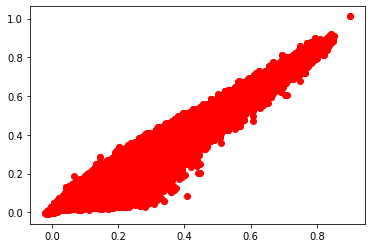

In [39]:
plt.plot(predicted, outputted, 'ro')
plt.show()